# Project: Multi-Omics Integration for Personalised Medicine

This Jupyter notebook will guide you through the project in the Introduction to Multi-Omics Integration and Visualisation course at EMBL-EBI. You'll explore how to use Multi-Omics Factor Analysis (MOFA) to analyze a dataset of Chronic Lymphocytic Leukemia patients. All practical exercises will take place within this notebook, ensuring you have everything you need in one place.

In [1]:
import os
import numpy as np
import pandas as pd
import anndata as ad
import mudata as md
import muon as mu
import mofax as mfx
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import decoupler as dc

## Prerequisites

Before getting started, ensure you're familiar with some key Python packages used in this project. The links below provide helpful introductions.

### NumPy
A library for numerical computing, providing the np.array class for vector and matrix operations. In this project, numerical data (e.g., mRNA counts) will typically be stored as NumPy arrays.

[NumPy Quickstart](https://numpy.org/doc/2.2/user/quickstart.html)

### Pandas
A powerful library for working with tabular data, offering the pd.DataFrame class. Unlike NumPy arrays, DataFrames allow labeled columns and rows, support multiple data types (e.g., integers and strings), and enable easy indexing by name.

[10 minutes to Pandas](https://pandas.pydata.org/docs/user_guide/10min.html)

### Matplotlib
The most widely used plotting library in Python. While mastering it takes time, this guide covers the essentials.

[Matplotlib Quick Start Guide](https://matplotlib.org/stable/users/explain/quick_start.html)

## Data handling

Now that you're prepared, let's dive into handling Omics and Multi-Omics data in Python. While you could work with standard arrays and DataFrames, more specialized options exist: AnnData and MuData. In the next sections, you'll get familiar with these powerful tools.

### AnnData

If you've worked with R, you probably know the SingleCellExperiment or SummarizedExperiment classes. AnnData is pretty much the same, but in Python.

<img src="graphics/anndata_schema.svg" alt="drawing" width="400"/>

An AnnData object has several key attributes:
- .X – The main data matrix, typically a count matrix with dimensions (n_observations × n_variables).
- .obs – A DataFrame containing metadata for each observation (row in .X), such as cell type or donor ID. Its index column can be accessed directly via .obs_names.
- .var – A DataFrame containing metadata for each variable (column in .X), such as a gene’s genomic location. Its index column can be accessed via .var_names.
- .obsm – A dictionary storing multi-dimensional observation data. Unlike .obs, which holds one-dimensional metadata (e.g., cell types), .obsm can store structured data like 2D UMAP coordinates or PCA components.
- .varm – The equivalent of .obsm for storing additional metadata related to variables.
- .layers – A dictionary for storing multiple versions of the data matrix (same shape as .X). This is useful for preserving raw counts while working with transformed versions (e.g., log-transformed data).
- .uns – A dictionary for miscellaneous information that doesn’t fit into observations or variables, such as dataset metadata or author contact details.
- .obsp & .varp – Rarely used; not covered in this guide.

Browse [AnnData Getting Started](https://anndata.readthedocs.io/en/latest/tutorials/notebooks/getting-started.html) to learn more!

Now, let's dive into some actual code! We'll start by downloading an example AnnData object included in the ScanPy package—a powerful Python library for single-cell analysis. If you're interested in learning more, I highly recommend checking out the [ScanPy tutorials](https://scanpy.readthedocs.io/en/stable/tutorials/index.html).

In [2]:
adata = sc.datasets.pbmc3k_processed()
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

#### Exercise
Take a closer look at the AnnData object and see what you can learn about the dataset. Answer the following questions—and if you need a hand, feel free to ask your favorite large language model (that's what they're here for!).

1. How many cells and genes are in the dataset?
2. Does .X contain raw mRNA counts, or has the data been processed in some way?
3. Examine the 'louvain' column in the .obs DataFrame. What information does it store, and how many unique values does it contain?
4. Find the PCA (Principal Component Analysis) projection of the data. How many components are included?
5. Visualizing embeddings:
    - Create a 2D scatter plot of the UMAP embedding using Matplotlib.
    - Compare it to the t-SNE embedding—do they look similar?
    - Color the dots by cell type.
    - Generate a plot showing only one cell type (subset the AnnData object before plotting).
    - Try using ScanPy’s built-in plotting functions instead of Matplotlib.


In [3]:
# Exercise 1

print("Number of cells:", adata.n_obs)
print("Number of genes:", adata.n_vars)

Number of cells: 2638
Number of genes: 1838


In [4]:
# Exercise 2

# print the values of the first 10 cells and genes
print(adata.X[:10, :10])

[[-0.17146951 -0.28081203 -0.04667679 -0.4751688  -0.54402375  4.9284954
  -0.03802771 -0.28057286 -0.34178796 -0.19536126]
 [-0.21458222 -0.37265295 -0.05480444 -0.68339145  0.6339506  -0.33483657
  -0.04558872 -0.49826393 -0.5419136  -0.20901662]
 [-0.37688747 -0.2950843  -0.0575275  -0.52097213  1.3326473  -0.30936235
  -0.10310837 -0.2725262  -0.50079846 -0.22022834]
 [-0.2852409  -0.2817346  -0.05222673 -0.48492876  1.5726788  -0.27182466
  -0.07455207 -0.25887555 -0.41675165 -0.20847097]
 [-0.2564834  -0.220394   -0.04680008 -0.34585932 -0.33340898 -0.20812184
  -0.06951413  5.806442   -0.2831118  -0.19935483]
 [-0.27125517 -0.26451087 -0.0504178  -0.44547978 -0.49266204 -0.25229883
  -0.07123657 -0.2192935  -0.3754224  -0.20523469]
 [-0.09565778 -0.27648515 -0.04273415 -0.4603669  -0.5231178  -0.2144933
  -0.01394444 -0.2858648   2.661892   -0.18627307]
 [-0.15813293 -0.27562705 -0.04569191 -0.46267566 -0.52448225  3.6938033
  -0.03409468 -0.2705804  -0.3234718  -0.19334242]
 [ 

In [5]:
# Exercise 3
print(adata.obs["louvain"].unique())

['CD4 T cells', 'B cells', 'CD14+ Monocytes', 'NK cells', 'CD8 T cells', 'FCGR3A+ Monocytes', 'Dendritic cells', 'Megakaryocytes']
Categories (8, object): ['CD4 T cells', 'CD14+ Monocytes', 'B cells', 'CD8 T cells', 'NK cells', 'FCGR3A+ Monocytes', 'Dendritic cells', 'Megakaryocytes']


In [6]:
# Exercise 4
print(adata.obsm["X_pca"].shape) # (number of cells, number of principal components)

(2638, 50)


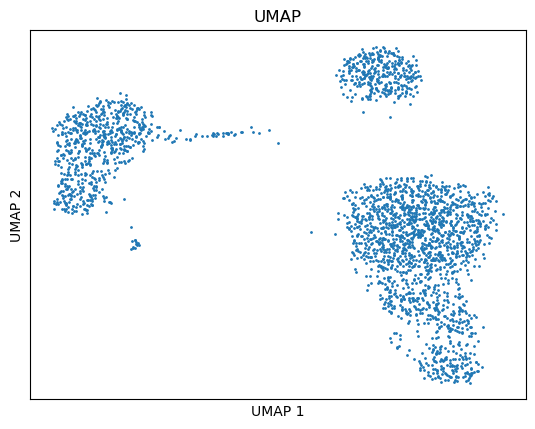

In [7]:
# Exercise 5a
plt.scatter(adata.obsm["X_umap"][:, 0], adata.obsm["X_umap"][:, 1], s=1)
plt.title("UMAP")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.xticks([])
plt.yticks([])
plt.show()

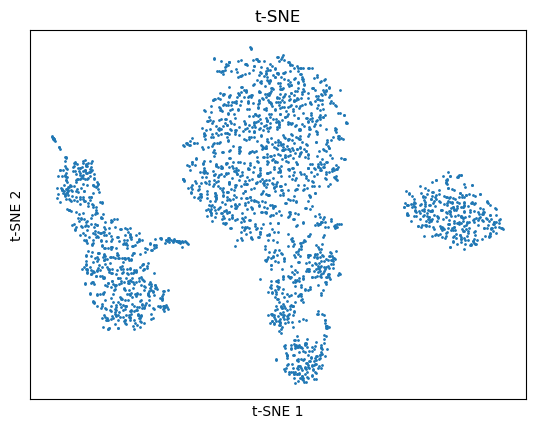

In [8]:
# Exercise 5b
plt.scatter(adata.obsm["X_tsne"][:, 0], adata.obsm["X_tsne"][:, 1], s=1)
plt.title("t-SNE")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.xticks([])
plt.yticks([])
plt.show()

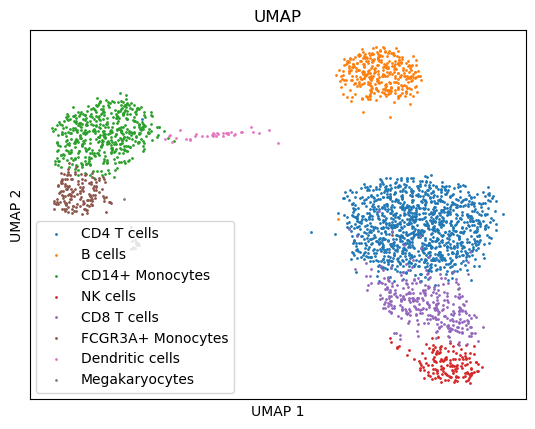

In [9]:
# Exercise 5c
fig, ax = plt.subplots()

for celltype in adata.obs["louvain"].unique():
    adata_celltype = adata[adata.obs["louvain"] == celltype]
    ax.scatter(adata_celltype.obsm["X_umap"][:, 0], adata_celltype.obsm["X_umap"][:, 1], s=1, label=celltype)

ax.set_title("UMAP")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_xticks([])
ax.set_yticks([])
plt.legend()
plt.show()

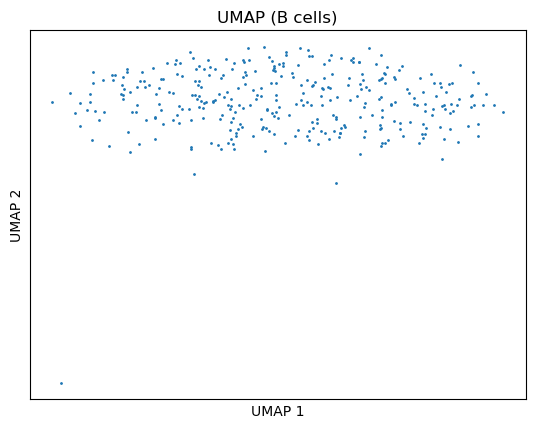

In [10]:
# Exercise 5d
adata_B_cells = adata[adata.obs["louvain"] == "B cells"]

plt.scatter(adata_B_cells.obsm["X_umap"][:, 0], adata_B_cells.obsm["X_umap"][:, 1], s=1)
plt.title("UMAP (B cells)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.xticks([])
plt.yticks([])
plt.show()

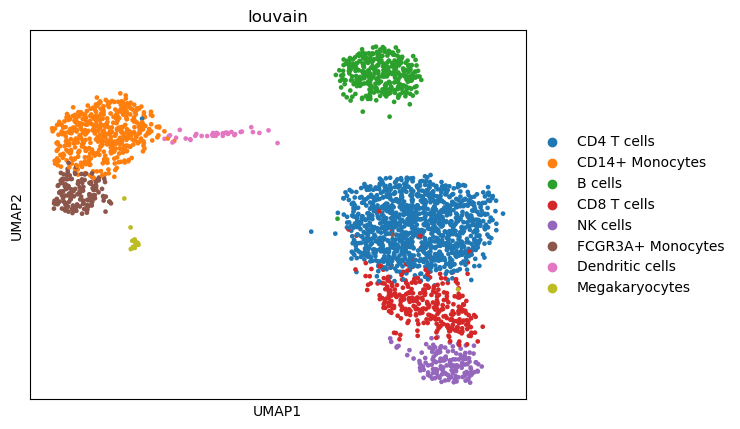

In [11]:
# Exercise 5e
sc.pl.umap(adata, color="louvain")

You're probably eager to analyze your own data! In the next section, we'll explore how to create an AnnData object from a common file format: CSV. If you need to load data from other formats, check out the [ScanPy reading functions](https://scanpy.readthedocs.io/en/stable/api/reading.html). (Fun fact: ScanPy even has a built-in CSV reader—but we won’t use it here to keep things a little more hands-on!)

We'll start by exploring the Chronic Lymphocytic Leukemia (CLL) dataset, focusing on a single modality: transcriptome measurements. Before diving into the code, open the CSV file in a text editor to see how it's structured.

Now, let's begin by loading the file as a Pandas DataFrame:

In [12]:
mrna_df = pd.read_csv("data/cll_mrna.csv", index_col=0).T

mrna_df

,ENSG00000244734,ENSG00000158528,ENSG00000198478,ENSG00000175445,ENSG00000174469,ENSG00000188536,ENSG00000186522,ENSG00000196263,ENSG00000198046,ENSG00000144642,...,ENSG00000136492,ENSG00000143198,ENSG00000161653,ENSG00000203778,ENSG00000177599,ENSG00000111328,ENSG00000165474,ENSG00000164061,ENSG00000166816,ENSG00000165972
H045,4.558644,11.741854,8.921456,12.686458,2.644946,2.644946,11.473792,9.680574,10.323723,11.137333,...,7.220013,10.177649,4.667130,7.052534,6.323287,10.059942,1.528848,5.771337,1.528848,5.256267
H109,2.721512,13.287432,2.721512,10.925985,12.648355,1.528848,10.271483,9.986980,10.231973,1.528848,...,7.947078,8.223803,4.775046,6.279164,5.799820,10.361200,1.528848,5.359180,2.383843,7.360436
H024,9.938456,2.341006,12.381452,1.528848,1.528848,6.664661,3.408744,3.657904,3.657904,2.341006,...,8.967320,10.096502,5.815616,6.369060,6.539086,8.152703,1.528848,6.059008,2.341006,5.715771
H056,13.278004,3.232874,8.106266,1.528848,13.565210,9.580385,3.410471,3.565827,3.232874,2.417160,...,8.532982,10.238564,5.902633,5.728777,5.929667,7.737858,2.417160,5.495087,3.232874,5.789100
H079,6.086874,11.940820,4.889503,13.340588,5.476914,3.862678,9.955379,10.244702,10.567114,7.967849,...,7.760580,8.790501,5.929477,5.833956,6.036300,8.274131,2.270282,5.102382,1.528848,6.316072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H070,3.254823,1.528848,1.528848,4.436292,12.418931,1.528848,1.528848,1.528848,1.528848,1.528848,...,8.410700,9.314123,4.956979,6.873084,6.070732,8.067587,1.528848,5.111537,1.528848,7.060619
H255,3.269304,12.427299,2.907226,11.425088,1.528848,2.344369,9.696142,10.988039,10.060879,5.343396,...,6.579472,10.558828,5.043407,6.954905,5.874135,8.751176,1.528848,5.726740,2.667779,5.986365
H135,1.528848,1.528848,1.528848,1.528848,12.815852,1.528848,1.528848,1.528848,1.528848,1.528848,...,7.178759,9.572243,3.491024,6.028750,5.038032,8.350212,1.528848,6.936723,1.528848,5.756981
H247,8.826116,3.121428,8.087886,5.680739,9.970217,5.836520,1.528848,7.679473,2.682078,3.121428,...,7.243387,9.173220,4.317162,6.526577,4.165399,9.158571,1.528848,4.517548,1.528848,6.241231


We've successfully loaded the data as a Pandas DataFrame, ensuring that the first column is recognized as the index. The gene names (row indices) and sample names (column headers) are already included, so we can now easily convert this DataFrame into an AnnData object.

In [13]:
mrna_adata = ad.AnnData(mrna_df)

mrna_adata

AnnData object with n_obs × n_vars = 136 × 5000

#### Exercise
1. Check the .obs_names and .var_names attributes. Do they match the DataFrame’s index and columns?
2. The previous overview didn’t show any .obs or .var entries. Can you still access them? Why might they be missing?
3. Load the data/cll_metadata.csv file into a Pandas DataFrame and inspect it. Make sure that the "Sample" column is the index. Then, try adding the "Age4Main" column to .obs. Notice that the metadata DataFrame has 265 rows, while the AnnData object only has 136. What does this mean? Do the sample names still align?
4. Subset the AnnData object to include only patients older than 70.
5. Load the data/cll_mutations.csv file and create another AnnData object. How many patients are included? Do they match the patients in the transcriptome data?

In [14]:
# Exercise 1
print(mrna_adata.obs_names[:10])
print((mrna_adata.obs_names == mrna_df.index).all())

print(mrna_adata.var_names[:10])
print((mrna_adata.var_names == mrna_df.columns).all())

Index(['H045', 'H109', 'H024', 'H056', 'H079', 'H164', 'H059', 'H167', 'H113',
       'H049'],
      dtype='object')
True
Index(['ENSG00000244734', 'ENSG00000158528', 'ENSG00000198478',
       'ENSG00000175445', 'ENSG00000174469', 'ENSG00000188536',
       'ENSG00000186522', 'ENSG00000196263', 'ENSG00000198046',
       'ENSG00000144642'],
      dtype='object')
True


In [15]:
# Exercise 2
print(mrna_adata.obs)
print(mrna_adata.var)

# the .obs and .var DataFrames exist, but they are currently empty

Empty DataFrame
Columns: []
Index: [H045, H109, H024, H056, H079, H164, H059, H167, H113, H049, H133, H103, H035, H121, H033, H064, H236, H238, H171, H018, H115, H117, H053, H148, H165, H114, H038, H240, H173, H187, H234, H060, H191, H118, H228, H100, H104, H054, H046, H099, H112, H110, H225, H019, H163, H233, H231, H111, H096, H042, H077, H088, H013, H031, H023, H017, H097, H057, H040, H010, H047, H105, H044, H030, H107, H094, H058, H028, H021, H119, H005, H016, H055, H080, H041, H043, H011, H102, H020, H014, H085, H022, H078, H015, H116, H029, H036, H072, H087, H095, H090, H108, H039, H083, H082, H073, H081, H027, H069, H101, ...]

[136 rows x 0 columns]
Empty DataFrame
Columns: []
Index: [ENSG00000244734, ENSG00000158528, ENSG00000198478, ENSG00000175445, ENSG00000174469, ENSG00000188536, ENSG00000186522, ENSG00000196263, ENSG00000198046, ENSG00000144642, ENSG00000022556, ENSG00000240563, ENSG00000105967, ENSG00000165810, ENSG00000134184, ENSG00000214787, ENSG00000095777, ENSG000001

In [16]:
# Exercise 3
metadata_df = pd.read_csv("data/cll_metadata.csv", index_col=0) # note that index_col=0 sets the 0th column as index
mrna_adata.obs["Age"] = metadata_df["Age4Main"] # automatically aligned because both DataFrames have the Sample ID as index

mrna_adata.obs

,Age
H045,90.731507
H109,85.465753
H024,NaN
H056,83.468493
H079,47.898630
...,...
H070,71.463014
H255,67.367123
H135,76.136986
H247,46.934247


In [17]:
# Exercise 4
mrna_older_than_70_adata = mrna_adata[mrna_adata.obs["Age"] > 70]
print(mrna_older_than_70_adata.n_obs)
mrna_older_than_70_adata.obs.head(10)

52


,Age
H045,90.731507
H109,85.465753
H056,83.468493
H164,73.260274
H103,70.742466
H035,79.487671
H064,71.016438
H238,74.501370
H171,73.046575
H115,72.460274


In [18]:
# Exercise 5
mutations_df = pd.read_csv("data/cll_mutations.csv", index_col=0).T

mutations_adata = ad.AnnData(mutations_df)
print(mutations_adata.n_obs)
print(np.intersect1d(mutations_adata.obs_names, mrna_adata.obs_names).shape)

200
(136,)


### MuData

Now, let's dive into Multi-Omics data! You’ve seen how useful AnnData is, but it's designed for a single omics modality. While you could theoretically store multiple modalities in the .layers attribute, this would require identical variables and observations—which is rarely the case. So, in short… not a great idea. Instead, we use MuData!

MuData is a generalization of AnnData for Multi-Omics datasets. It allows you to combine multiple AnnData objects, where observations (samples) at leasst partially overlap but variables (features) differ. This is the perfect time to get familiar with the MuData package!

[MuData Quickstart](https://mudata.readthedocs.io/en/latest/notebooks/quickstart_mudata.html)

#### Exercise

We'll now set up the MuData object that will be used for MOFA analysis throughout the project. This involves:

1. Creating AnnData objects for each modality (transcriptome, methylation, mutations, drug response).
2. Storing these objects in a dictionary.
3. Passing the dictionary to MuData, which will automatically generate a MuData object.

##### Load the Metadata
Start by loading the metadata as before. We'll convert the categorical variables "Sex", "died" and "IGHV" to numerical values to deal with them more easily later.

In [19]:
metadata_df = pd.read_csv("data/cll_metadata.csv", index_col=0)

# assuming you called the DataFrame `metadata_df`
metadata_df.rename(columns={"Gender" : "Sex"}, inplace=True)
metadata_df.replace({"Sex" : {"m" : 0, "f" : 1}}, inplace=True)
metadata_df.replace({"died" : {False : 0, True : 1}}, inplace=True)
metadata_df.replace({"IGHV" : {"U" : 0, "M" : 1}}, inplace=True)
metadata_df.fillna(-1, inplace=True)

metadata_df

/var/folders/8j/6swtmv_s3zlbsygt04f92_480000gp/T/ipykernel_11298/1497086161.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  metadata_df.replace({"Sex" : {"m" : 0, "f" : 1}}, inplace=True)
/var/folders/8j/6swtmv_s3zlbsygt04f92_480000gp/T/ipykernel_11298/1497086161.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  metadata_df.replace({"died" : {False : 0, True : 1}}, inplace=True)
/var/folders/8j/6swtmv_s3zlbsygt04f92_480000gp/T/ipykernel_11298/1497086161.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and

,Diagnosis,Sex,IGHV,Age4Main,T5,T6,treatedAfter,died,IC50beforeTreatment,ConsClust
Sample,,,,,,,,,,
H001,hMNC,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1,-1.0,-1,-1
H002,hMNC,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1,-1.0,-1,-1
H003,hMNC,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1,-1.0,-1,-1
H005,CLL,0.0,1.0,75.265753,0.574949,2.625599,True,0.0,False,IP
H006,CLL,0.0,1.0,-1.000000,-1.000000,-1.000000,-1,-1.0,-1,HP
...,...,...,...,...,...,...,...,...,...,...
H276,AML,0.0,-1.0,61.838356,-1.000000,-1.000000,-1,-1.0,-1,-1
H277,AML,0.0,-1.0,82.578082,-1.000000,-1.000000,-1,-1.0,-1,-1
H278,AML,0.0,-1.0,75.290411,-1.000000,-1.000000,-1,-1.0,-1,-1


##### Load the Transcriptome Data
Next, load the transcriptome data as before. However, you might have noticed that the .var_names attribute contains ENSEMBL Gene IDs, while we want to use Gene Symbols instead.

The mapping between ENSEMBL IDs and Gene Symbols is stored in the cll_gene_ids.csv file. Some pre-written code is available to help with this conversion—go ahead and use it!

In [20]:
mrna_df = pd.read_csv("data/cll_mrna.csv", index_col=0).T
mrna_adata = ad.AnnData(mrna_df)

# assuming you called the AnnData object `adata_mrna`
gene_ids = pd.read_csv(os.path.join("data/cll_gene_ids.csv"), index_col=0)
cols = list(mrna_adata.var_names)
cols = [gene_ids.loc[gene_ids["GENEID"] == gene, "SYMBOL"].item() for gene in cols]
mrna_adata.var_names = cols

mrna_adata

AnnData object with n_obs × n_vars = 136 × 5000

##### Load the Mutations Data
Now, load the mutations data from data/cll_mutations.csv.

Since we’ll be combining multiple AnnData objects into a MuData object, each must have unique variable names. However, there's a potential issue: The .var_names in the mutations data may be gene names, which are already used in the transcriptome AnnData.

To avoid conflicts, some pre-written code automatically prepends "m_" to each variable name in the mutations data, ensuring uniqueness. Go ahead and apply this fix!

In [21]:
mutations_df = pd.read_csv("data/cll_mutations.csv", index_col=0).T
mutations_adata = ad.AnnData(mutations_df)

# assuming you called the AnnData object `adata_mutations`
mutations_adata.var_names = [f"m_{x}" for x in mutations_adata.var_names]

mutations_adata

AnnData object with n_obs × n_vars = 200 × 69

##### Load the Methylation Data
Next, load the methylation data from data/cll_methylation.csv.

In [22]:
methylation_df = pd.read_csv("data/cll_methylation.csv", index_col=0).T
methylation_adata = ad.AnnData(methylation_df)

methylation_adata

AnnData object with n_obs × n_vars = 200 × 4248

##### Load the Drug Response Data
Load the drug response data from data/cll_drugs.csv. This only contains the drug IDs, and we will replace them with the drug names using the pre-written code.

In [23]:
drugs_df = pd.read_csv("data/cll_drugs.csv", index_col=0).T
drugs_adata = ad.AnnData(drugs_df)

# assuming you called the AnnData object `adata_drugs`
drug_names = pd.read_csv("data/drugs.txt", sep=",", index_col=0)
mapping = drug_names["name"].to_dict()
cols = []
for k in drugs_adata.var_names:
    for v in mapping.keys():
        if v in k:
            cols.append(k.replace(v, mapping[v]))
            break

drugs_adata.var_names = cols

drugs_adata

AnnData object with n_obs × n_vars = 200 × 310

##### Combine Modalities and Load Metadata
Now that you’ve prepared all the AnnData objects, it's time to combine them into a MuData object! Create a dictionary `modality_dict`, where:
- The keys are the names of the individual modalities (e.g., "mrna", "methylation", "mutations", "drugs").
- The values are the corresponding AnnData objects.

Then, create a MuData object from this dictionary using `mdata = md.MuData(modality_dict)` and add metadata using `mdata.obs = metadata.loc[mdata.obs_names]` (assuming you named your metadata DataFrame metadata).

Now your MuData object is ready for analysis!

In [24]:
modality_dict = {
    "mrna" : mrna_adata,
    "mutations" : mutations_adata,
    "methylation" : methylation_adata,
    "drugs" : drugs_adata
}

mdata = md.MuData(modality_dict)
mdata.obs = metadata_df.loc[mdata.obs_names]

mdata

/Users/fwalter/micromamba/envs/mofa-workshop/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/Users/fwalter/micromamba/envs/mofa-workshop/lib/python3.10/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


MuData object with n_obs × n_vars = 200 × 9627
  obs:	'Diagnosis', 'Sex', 'IGHV', 'Age4Main', 'T5', 'T6', 'treatedAfter', 'died', 'IC50beforeTreatment', 'ConsClust'
  4 modalities
    mrna:	136 x 5000
    mutations:	200 x 69
    methylation:	200 x 4248
    drugs:	200 x 310

Well done. Data preparation is often the most time-consuming and challenging part of a data analysis project, but it sets the foundation for everything that follows. The next steps will be more focused on analysis and interpretation.

#### Exercise
Before moving forward, take some time to develop an intuition for the dataset.
1. Check for missing values: What percentage of values are missing in each modality? How many features does each modality contain?
2. Interpret the data matrix: What do the numerical values in each modality represent?
3. Visualize the data distribution: Use the histplot function from the seaborn package to plot the distribution of values for each modality. What should you expect this distribution to look like?

Understanding these aspects will help in making informed decisions during analysis.

In [25]:
# Exercise 1
print("Percentage of missing values in each modality:")
for modality in mdata.mod_names:
    print(modality, np.isnan(mdata[modality].X).mean())

print("Number of features in each modality:")
for modality in mdata.mod_names:
    print(modality, mdata[modality].n_vars)

Percentage of missing values in each modality:
mrna 0.0
mutations 0.33760869565217394
methylation 0.02
drugs 0.08
Number of features in each modality:
mrna 5000
mutations 69
methylation 4248
drugs 310


In [26]:
# Exercise 2
for modality in mdata.mod_names:
    print(modality, mdata[modality].X[:2, :2])

# mrna: transformed counts
# mutations: binary
# methylation: M-value
# drugs: viability score

mrna [[ 4.55864355 11.74185387]
 [ 2.72151227 13.28743173]]
mutations [[0. 0.]
 [0. 0.]]
methylation [[ 1.81108585 -5.17257225]
 [-3.99750846  1.59487016]]
drugs [[0.02363938 0.04623274]
 [0.073599   0.10623002]]


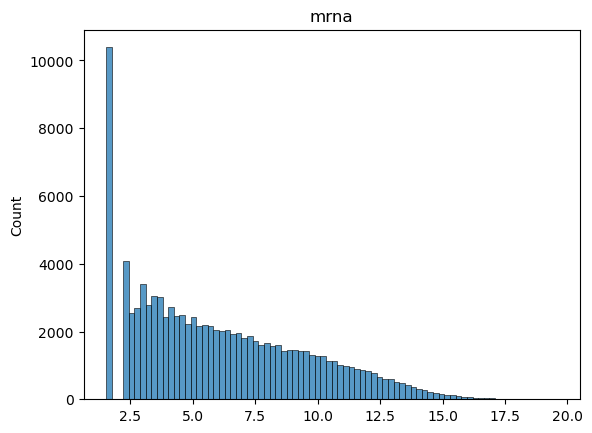

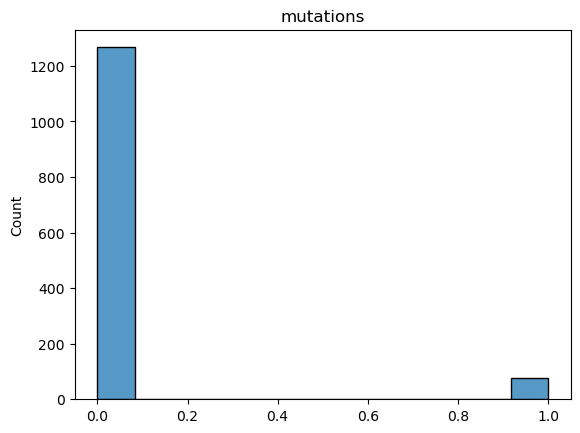

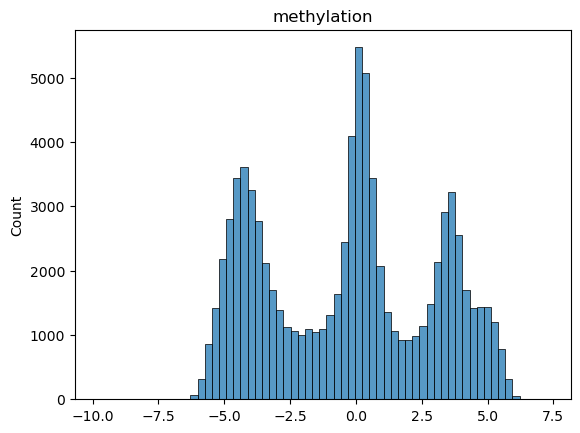

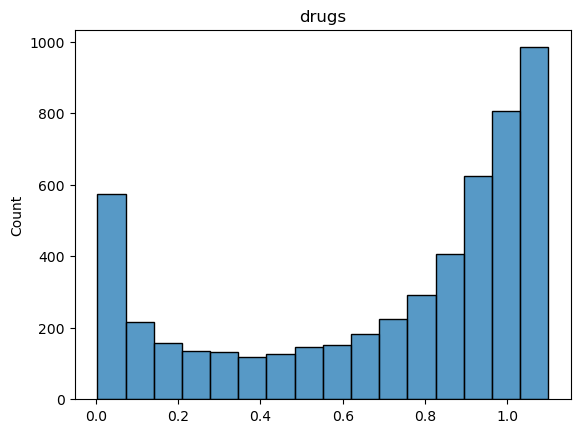

In [27]:
# Exercise 3
for modality in mdata.mod_names:
    fig, ax = plt.subplots()
    sns.histplot(mdata[modality].X[:20].flatten(), ax=ax) # just plot the first 20 samples
    ax.set_title(modality)
    plt.show()

## Training a MOFA Model

Now that the data is prepared, we are ready to train the MOFA model. This step is straightforward thanks to the structured data format we have set up.

While the original mofapy2 package can be used for this, a more convenient option is the muon package, which provides a simplified interface for multi-omics analysis. muon supports MuData objects directly while still using mofapy2 behind the scenes.

In the next steps, we will train the MOFA model using muon and explore its results.

In [28]:
# if you're not sure about your prepared mdata object, uncomment the following lines
# from data_loader import load_cll
# mdata = load_cll()

# assuming you called the MuData object `mdata``
mu.tl.mofa(
    mdata,
    use_obs="union",
    n_factors=15,
    convergence_mode="slow",
    outfile="models/cll.hdf5",
    save_metadata=True,
    save_data=True,
    verbose=False,
    ard_weights=True,
    ard_factors=True,
    spikeslab_weights=True,
    spikeslab_factors=False,
    seed=42,
)



        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='mrna' group='group1' with N=200 samples and D=5000 features...
Loaded view='mutations' group='group1' with N=200 samples and D=69 features...
Loaded view='methylation' group='group1' with N=200 samples and D=4248 features...
Loaded view='drugs' group='group1' with N=200 samples and D=310 features...


Model options:
- Automatic Relevance Determination prior on the f

#### Exercise

Make sure you understand all the input parameters of MOFA. If you're not sure, it's a good idea to look them up in the [documentation](https://muon.readthedocs.io/en/latest/omics/multi.html).

### Inspection of the trained model

We'll now have a look at the result of our model training. For this, we'll load the trained model with mofax, a package to work with and visualise trained MOFA models.

In [29]:
model = mfx.mofa_model("models/cll.hdf5")
model

MOFA+ model: cll
Samples (cells): 200
Features: 9627
Groups: group1 (200)
Views: drugs (310), methylation (4248), mrna (5000), mutations (69)
Factors: 15
Expectations: W, Z

(<Figure size 640x480 with 1 Axes>, <Axes: >)

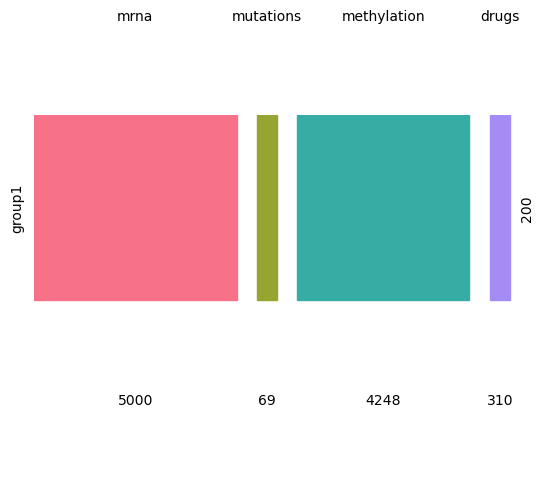

In [30]:
mfx.plot_data_overview(model)

One useful property of a trained MOFA model is its ability to quantify the explained variance (R²) for each factor in every modality. This helps assess the importance of different factors across modalities.

If a factor explains little to no variance in any modality, it is likely not very informative and can be deprioritized in further analysis. Instead, focus on factors that contribute significantly to one or more modalities, as these are more likely to capture meaningful biological variation.

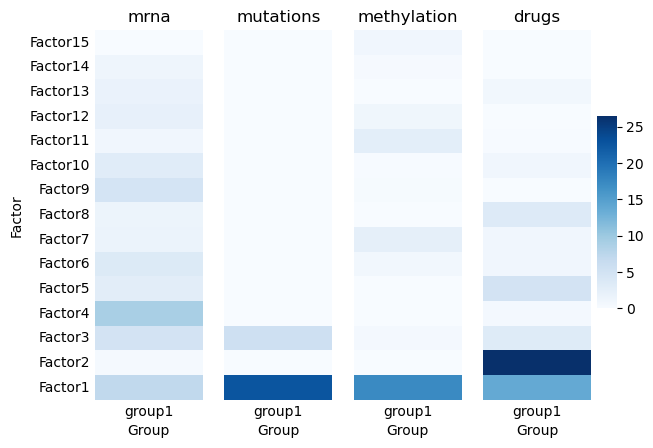

In [31]:
mfx.plot_r2(model)

Examining the correlation of factor scores is also important. If two or more factors are highly correlated, they may be capturing the same underlying variation. In such cases, it might be reasonable to focus on just one of them to simplify the analysis without losing meaningful information.

<Axes: >

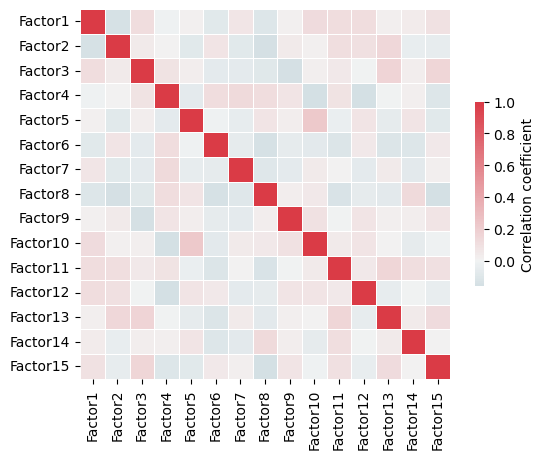

In [32]:
mfx.plot_factors_correlation(model)

#### Exercise

1. Train a second MOFA model with a different number of factors. Make sure to save it under a different name. Load the new model using mofax and re-plot the explained variance and factor score correlations. Do you observe similar patterns compared to the first model?
2. Compare total explained variance: How does the total explained variance change between the two models? Is the difference in variance explained consistent with what you expected?
3. Choosing the right number of factors:
   - Why is selecting too many factors problematic?
   - Why can too few factors limit the model’s usefulness?
   - What is the trade-off between interpretability and capturing meaningful variation?

Understanding these points will help optimize MOFA for meaningful biological insights.

In [33]:
# Exercise 1

# assuming you called the MuData object `mdata``
mu.tl.mofa(
    mdata,
    use_obs="union",
    n_factors=5,
    convergence_mode="slow",
    outfile="models/cll_5_factors.hdf5",
    save_metadata=True,
    save_data=True,
    verbose=False,
    ard_weights=True,
    ard_factors=True,
    spikeslab_weights=True,
    spikeslab_factors=False,
    seed=42,
)

model_5_factors = mfx.mofa_model("models/cll_5_factors.hdf5")


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='mrna' group='group1' with N=200 samples and D=5000 features...
Loaded view='mutations' group='group1' with N=200 samples and D=69 features...
Loaded view='methylation' group='group1' with N=200 samples and D=4248 features...
Loaded view='drugs' group='group1' with N=200 samples and D=310 features...


Model options:
- Automatic Relevance Determination prior on the f

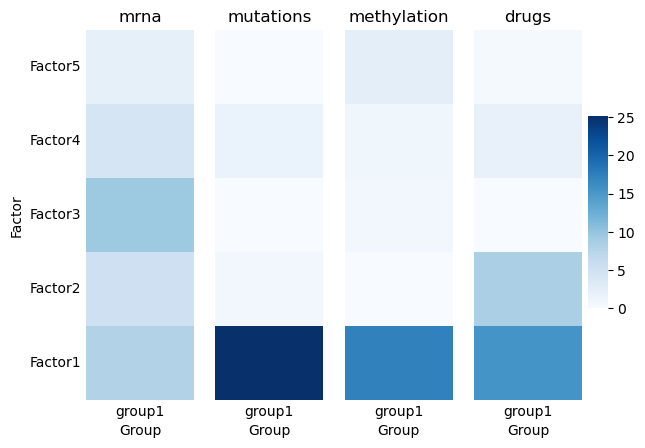

In [34]:
mfx.plot_r2(model_5_factors)

<Axes: >

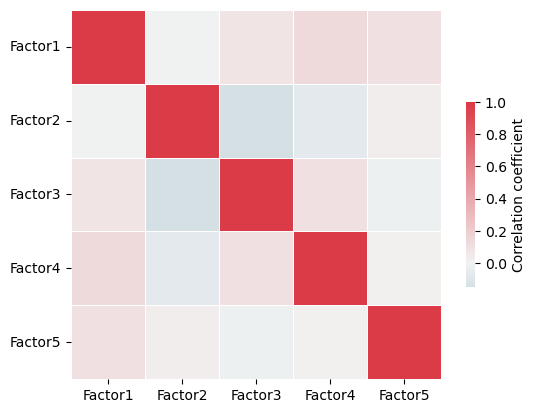

In [35]:
mfx.plot_factors_correlation(model_5_factors)

In [36]:
# Exercise 2
print("Model with 15 factors:")
print(model.get_r2().groupby("View").R2.sum())
print("Model with 5 factors:")
print(model_5_factors.get_r2().groupby("View").R2.sum())

Model with 15 factors:
View
drugs          56.347176
methylation    26.737102
mrna           45.026087
mutations      28.371116
Name: R2, dtype: float64
Model with 5 factors:
View
drugs          26.259544
methylation    21.646174
mrna           29.092087
mutations      27.489597
Name: R2, dtype: float64


In [37]:
# Exercise 3:
# too few factors lead to an underparameterised model that cannot explain the variation in the data
# too many factors lead to an overparameterised model that explains a lot of variation but does not efficiently reduce the dimensionality
# a model with fewer factors is more interpretable, while a model with more factors captures more variation

## Downstream Analysis Part I - Understanding the Factor Scores

The factor scores matrix has dimensions (n_samples × n_factors), meaning that for each sample, we have a set of inferred factor values. These scores capture patterns and variation in the multi-omics data.

You can extract the factor scores as a NumPy array, giving you full flexibility for custom analysis and visualization. However, both mofax and muon provide built-in plotting functions to simplify the process.

In the next steps, we will explore how to analyze and interpret these factor scores effectively.

In [38]:
model = mfx.mofa_model("models/cll.hdf5")
factor_scores = model.get_factors()

print(type(factor_scores))
print(factor_scores.shape)

<class 'numpy.ndarray'>
(200, 15)


To make the factor scores easier to interpret, we can convert the NumPy array into a Pandas DataFrame and add appropriate row and column labels:
- Rows represent samples (referred to as "cells" in mofax, but these are bulk samples in our case).
- Columns represent factors, making it clear which factor score corresponds to which sample.

This structured format makes the data easier to analyze, sort, and visualize.

In [39]:
factor_scores_df = pd.DataFrame(
    factor_scores,
    index=model.get_cells()["cell"].values,
    columns=[f"Factor {i}" for i in range(1, factor_scores.shape[1]+1)],
    )

factor_scores_df

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10,Factor 11,Factor 12,Factor 13,Factor 14,Factor 15
H045,-2.458745,1.229912,-0.127734,-2.996863,0.048013,1.698746,-1.715951,-0.207454,0.167125,-0.930906,0.177369,-1.320980,0.467388,0.344596,-2.104249
H109,-2.475325,0.993469,3.094953,-0.816009,0.727318,-1.919723,-2.100451,0.315487,-2.283106,0.486327,-0.373225,-2.148251,-0.184103,0.042696,-1.996205
H024,2.864018,0.192141,-1.143042,2.493335,0.567537,0.116039,-0.656372,-0.491053,3.553237,0.336303,2.148346,0.533634,-0.156824,-0.008489,-2.258565
H056,2.096964,-0.069930,-0.912751,2.850509,0.614771,-0.235696,0.652970,-1.016796,2.072061,0.550627,1.853905,0.562679,0.834804,-0.391517,-2.173087
H079,-2.137397,0.705485,-0.859077,-2.837120,-3.010952,0.984281,-1.037665,0.060039,-1.063539,0.638365,0.451500,-0.451103,0.101904,0.019902,-2.118670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H175,-2.602702,0.670186,-1.579474,-1.925490,-0.024672,0.014690,-0.709984,1.115079,-6.616106,1.731353,0.571103,-0.250521,1.627941,-1.003934,3.000790
H179,2.129145,0.230448,0.036470,-1.172906,-3.764899,-0.990841,-0.506838,0.867609,0.360701,-2.202339,1.899313,-2.373614,0.863917,-0.719116,3.015843
H050,4.028693,-0.157403,1.086095,-0.553077,1.522687,0.393043,-1.103651,0.295543,0.000265,0.877491,-0.142568,0.124076,-0.899585,0.000128,0.004704
H180,-2.457202,0.438737,-0.623183,-5.414265,-0.710354,-2.646390,-1.054615,-1.751798,-0.000802,0.573939,-0.223161,-0.219240,-0.138087,-0.001261,-0.121564


We can visualize the factor scores using a heatmap:

<Axes: >

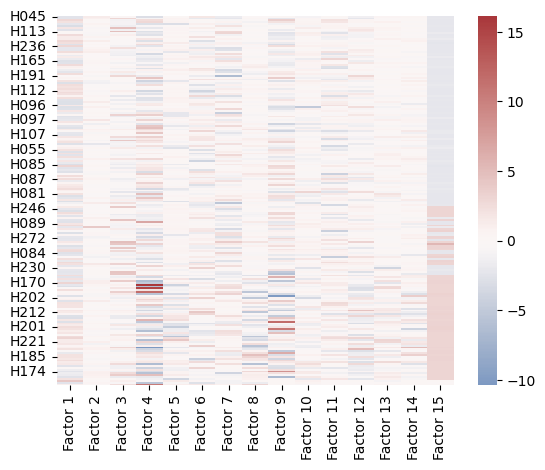

In [40]:
sns.heatmap(factor_scores_df, cmap="vlag", center=0)

We can visualize the relationship between two individual factors by using the plot_factors_scatter function.

This scatter plot helps identify potential correlations or patterns between factors. If the points form a clear trend (e.g., linear or clustered patterns), it suggests a relationship between the selected factors. If no structure is visible, the factors may capture independent sources of variation.

<Axes: title={'center': 'group'}, xlabel='Factor 1', ylabel='Factor 2'>

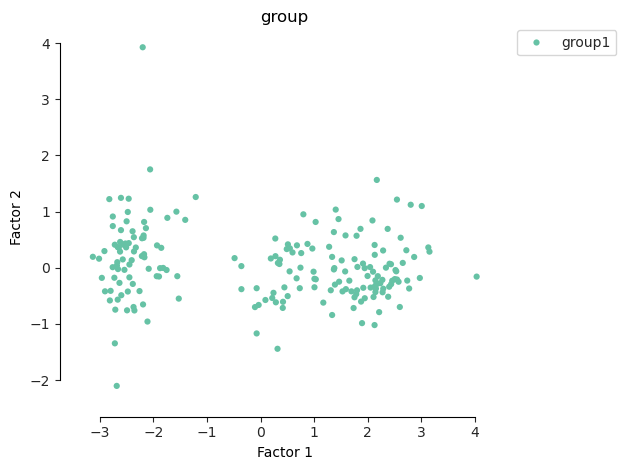

In [41]:
mfx.plot_factors_scatter(model, x="Factor 1", y="Factor 2")

#### Exercise
1. Identify two uncorrelated factors using the factor correlation plot from earlier.
2. Create a scatter plot of their factor scores using the plot_factors_scatter function. Do you see a random distribution of points, confirming they are uncorrelated?
3. Find highly correlated or anticorrelated factors and plot their scores. How strong is the relationship?

In [42]:
# Exercise 1
# 2 and 4 have relatively low correlation
# 5 and 10 have relatively high correlation


<Axes: title={'center': 'group'}, xlabel='Factor 2', ylabel='Factor 4'>

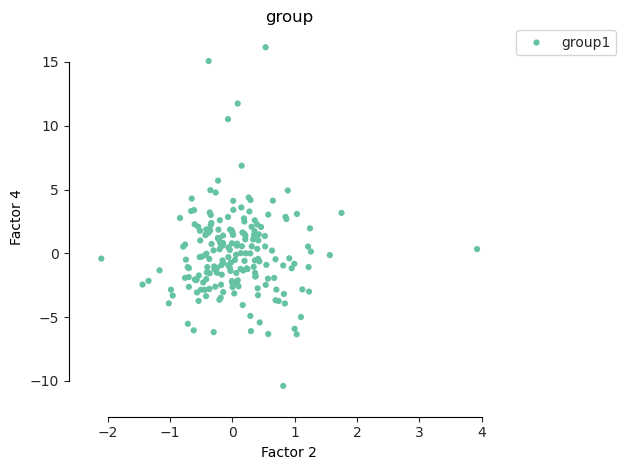

In [43]:
# Exercise 2
mfx.plot_factors_scatter(model, x="Factor 2", y="Factor 4")

<Axes: title={'center': 'group'}, xlabel='Factor 5', ylabel='Factor 10'>

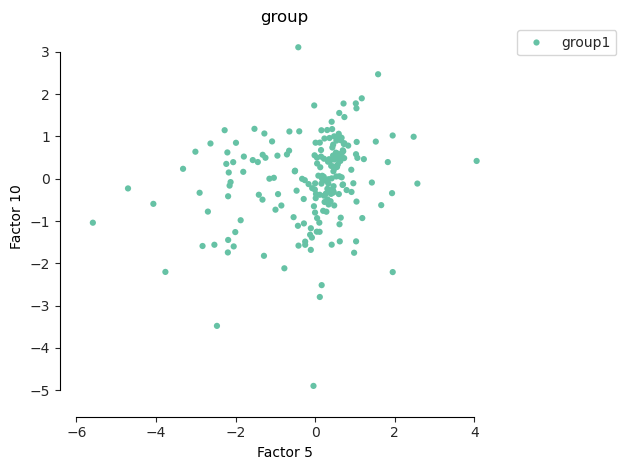

In [44]:
mfx.plot_factors_scatter(model, x="Factor 5", y="Factor 10")

Some factors may naturally separate samples into distinct groups. These factors are often particularly interesting, because they tell us something about the biological differences between those groups. It’s useful to check whether these groups correspond to known metadata by coloring the dots in the scatter plot accordingly.

As you can see in the next code cell, Factor 1 differentiates patients based on IGHV mutation status.

<Axes: title={'center': 'IGHV'}, xlabel='Factor 1', ylabel='Factor 2'>

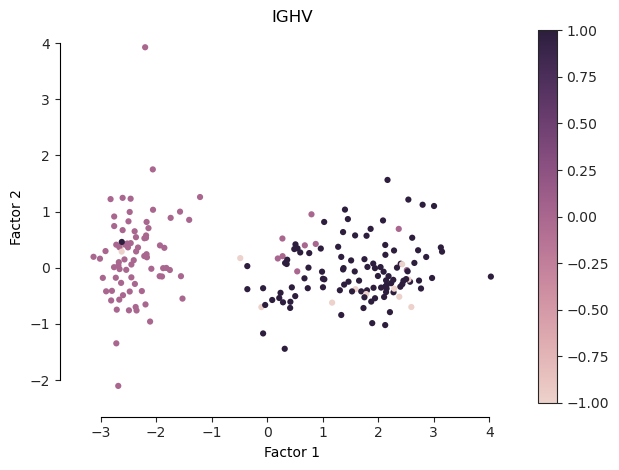

In [45]:
mfx.plot_factors_scatter(model, x="Factor 1", y="Factor 2", color="IGHV")

To make this correlation even more clear, we can use violin plots for visualisation.

<Axes: xlabel='IGHV', ylabel='Factor 1'>

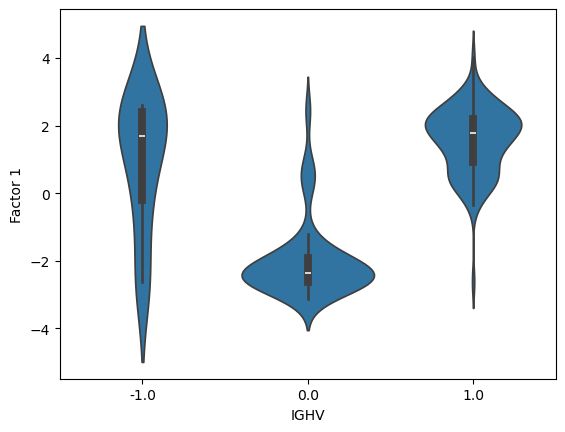

In [46]:
factor_scores_df["IGHV"] = model.metadata["IGHV"]
sns.violinplot(data=factor_scores_df, x="IGHV", y="Factor 1")

The IGHV mutation status was already stored in the metadata, allowing us to easily use it for coloring the scatter plot.

Now, let’s explore another variable from the mutations modality: m_trisomy12. Before using it for visualization, we need to add it to the metadata DataFrame. This ensures that we can access and plot it in the same way as other metadata variables.

Once added, you can use it to check if any factors separate samples based on trisomy 12 status.

In [47]:
model.metadata["trisomy12"] = mdata["mutations"][:, "m_trisomy12"].X.flatten().copy()
model.metadata["trisomy12"].fillna(-1, inplace=True)

#### Exercise
1. Plot the factor scores for two factors and color the dots according to the trisomy 12 status of the respective sample. Can you find factors that separate patients by trisomy 12 status? If so, make another violin plot.
2. Make one scatter plot with one factor that separates patients by IGHV status and one that separates them by trisomy 12 status.
3. How many groups of patients seem to be present in the data set according to these factors?

<Axes: title={'center': 'trisomy12'}, xlabel='Factor 3', ylabel='Factor 4'>

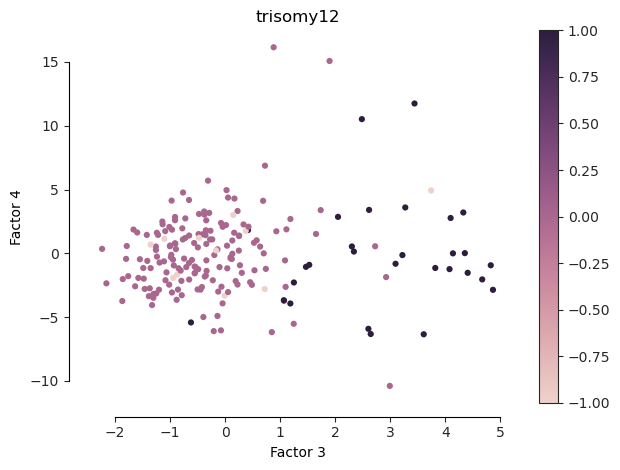

In [48]:
# Exercise 1
mfx.plot_factors(model, x="Factor 3", y="Factor 4", color="trisomy12")
# factor 3 separates the trisomy12 samples from the rest

<Axes: title={'center': 'trisomy12'}, xlabel='Factor 1', ylabel='Factor 3'>

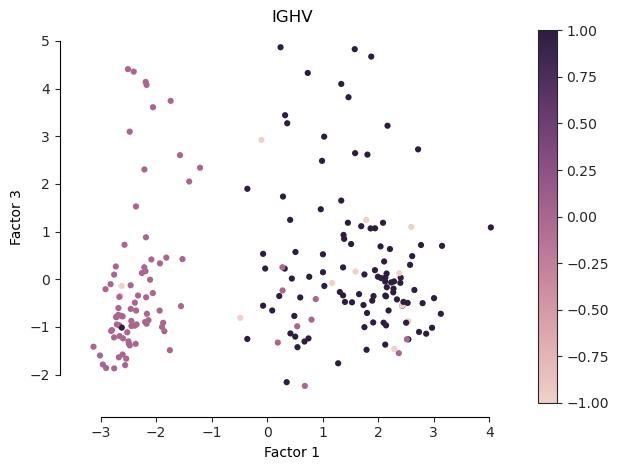

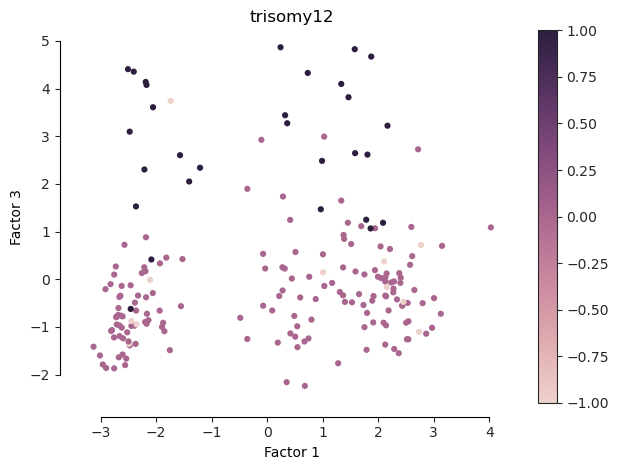

In [49]:
# Exercise 2
mfx.plot_factors(model, x="Factor 1", y="Factor 3", color="IGHV")
mfx.plot_factors(model, x="Factor 1", y="Factor 3", color="trisomy12")
# according to the plots, there seem to be 4 patient groups (separated by IGHV and trisomy12 status)

Alternatively, to check whether a factor correlates with any numerical variable, we can also use the plot_factors_covariates_correlation function from mofax to test all factors at the same time:

<Axes: >

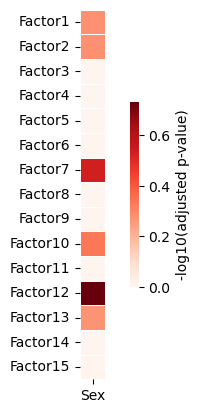

In [50]:
mfx.plot_factors_covariates_correlation(
    model, covariates=mdata.obs[["Sex"]], pvalues=True
)

#### Exercise

This one might be a bit more challenging. You've seen in the plot above that Factor 1 separates samples by their IGHV status. However, there are a few samples for which we do not have this information (we set their value to -1 in the beginning). Try to use a simple machine learning algorithm for classification (I would suggest [KNN Classification](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification)) to determine these patients' IGHV status. Hint: First, train the KNN model on the factor scores without the missing samples and then use it to predict the IGHV status of the missing samples.

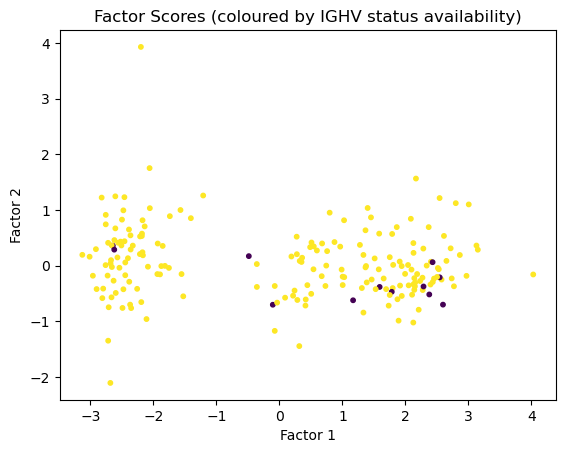

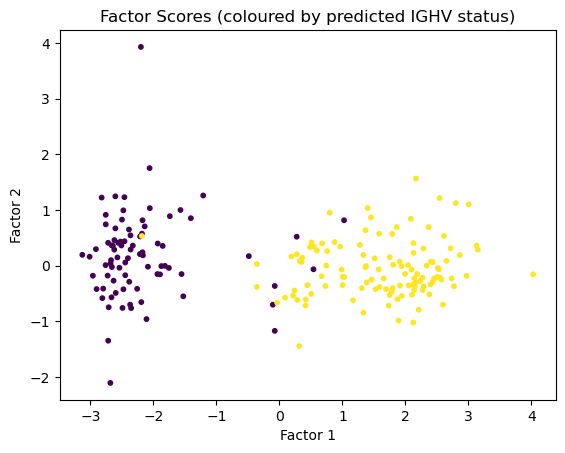

In [51]:
from sklearn.neighbors import KNeighborsClassifier

factors = model.get_factors()

# we first split the patients in a group where we know IGHV status and one where we don't
factors_train = factors[mdata.obs["IGHV"].isin([0, 1])]
factors_test = factors[mdata.obs["IGHV"] == -1]
status_train = mdata.obs[mdata.obs["IGHV"].isin([0, 1])]["IGHV"]
# status_test = ?

# now we train a classifier with the training data
classifier = KNeighborsClassifier().fit(factors_train, status_train)

# and use the classifier to predict IGHV status on the test data (where we don't know it)
status_predict = classifier.predict(factors)

# we can plot the results
fig, ax = plt.subplots()
ax.scatter(factors[:, 0], factors[:, 1], c=mdata.obs["IGHV"].isin([0, 1]), s=10)
ax.set_title("Factor Scores (coloured by IGHV status availability)")
ax.set_xlabel("Factor 1")
ax.set_ylabel("Factor 2")
plt.show()

fig, ax = plt.subplots()
ax.scatter(factors[:, 0], factors[:, 1], c=status_predict, s=10)
ax.set_title("Factor Scores (coloured by predicted IGHV status)")
ax.set_xlabel("Factor 1")
ax.set_ylabel("Factor 2")
plt.show()

## Downstream Analysis Part II - Understanding the factor loadings
So far, we've observed that:

- Factor 1 is important across all modalities and likely captures general variation between patients.
- Factor 1 helps separate patients with and without IGHV mutation.
- Factor 3 helps distinguish patients with and without trisomy 12.

Now, let’s dive deeper into these factors by examining their factor loadings in the different modalities.

Factor loadings (or weights) describe how strongly each variable in a modality contributes to a factor. By analyzing these loadings, we can link specific variables to the factors and understand their biological relevance.

You can extract the factor loadings as NumPy arrays for each modality, which will allow you to explore the relationships between individual variables and the inferred factors.

In [52]:
factor_loadings_mrna = model.get_weights("mrna")
factor_loadings_drugs = model.get_weights("drugs")
factor_loadings_methylation = model.get_weights("methylation")
factor_loadings_mutations = model.get_weights("mutations")

Let's convert them to DataFrames and add variable and factor names.

In [53]:
factor_loadings_mrna_df = pd.DataFrame(
    factor_loadings_mrna,
    index=model.get_features("mrna")["feature"].values,
    columns=[f"Factor {i}" for i in range(1, factor_loadings_mrna.shape[1]+1)],
)

factor_loadings_drugs_df = pd.DataFrame(
    factor_loadings_drugs,
    index=model.get_features("drugs")["feature"].values,
    columns=[f"Factor {i}" for i in range(1, factor_loadings_drugs.shape[1]+1)],
)

factor_loadings_methylation_df = pd.DataFrame(
    factor_loadings_methylation,
    index=model.get_features("methylation")["feature"].values,
    columns=[f"Factor {i}" for i in range(1, factor_loadings_methylation.shape[1]+1)],
)

factor_loadings_mutations_df = pd.DataFrame(
    factor_loadings_mutations,
    index=model.get_features("mutations")["feature"].values,
    columns=[f"Factor {i}" for i in range(1, factor_loadings_mutations.shape[1]+1)],
)

These factor loadings can be visualised with heatmaps as well:

<Axes: >

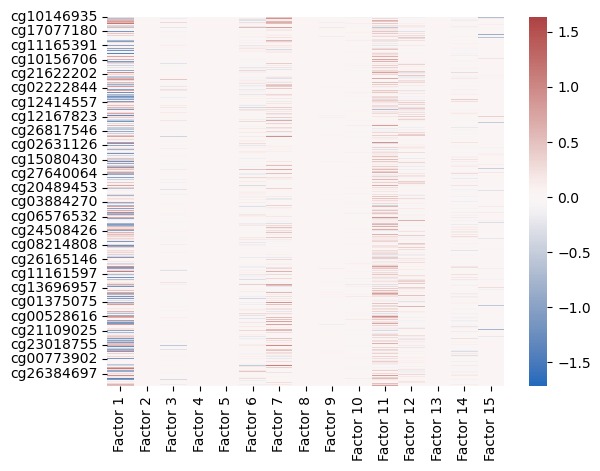

In [54]:
sns.heatmap(factor_loadings_methylation_df, cmap="vlag", center=0)

We can also use the mofax plotting function plot_weights_heatmap to show the variables with the highest absolute factor loading value in a view.

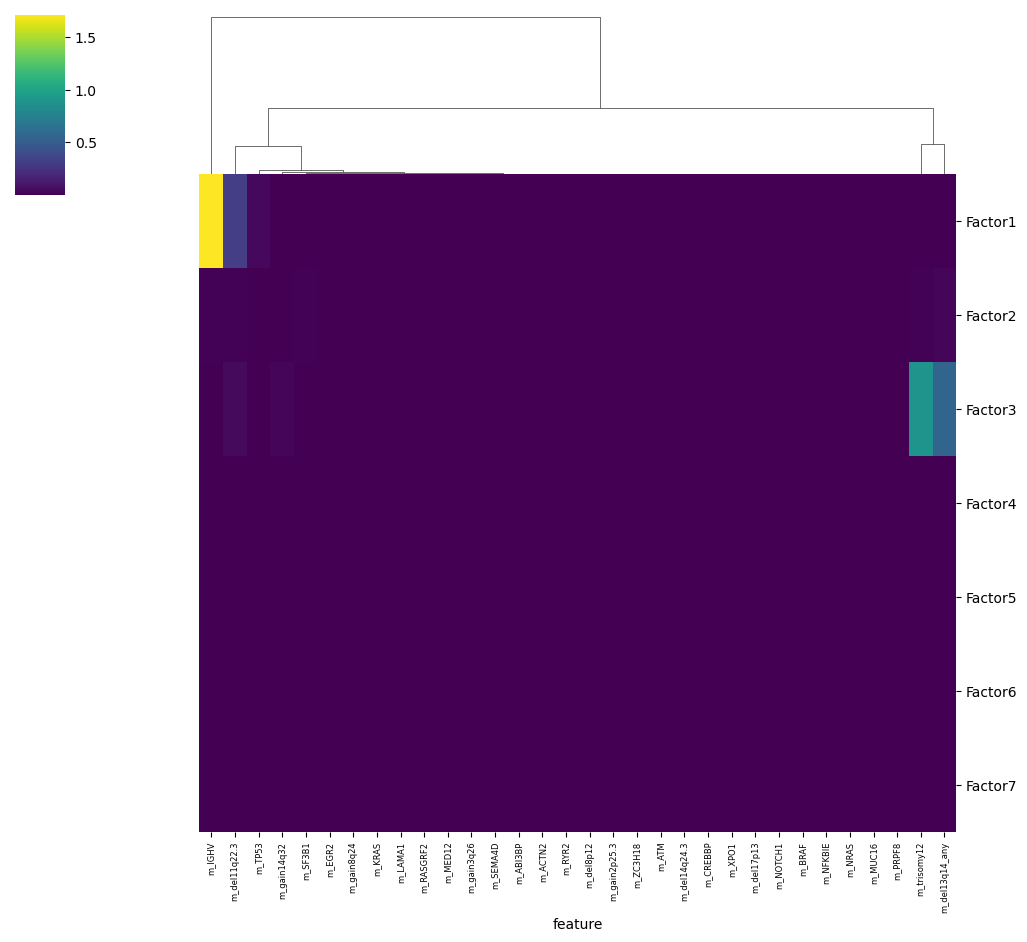

In [55]:
mfx.plot_weights_heatmap(
    model,
    n_features=10,
    view=1,
    factors=range(0, 7),
    xticklabels_size=6,
    w_abs=True,
    cmap="viridis",
    cluster_factors=False,
)


Or, alternatively as a scatter plot:

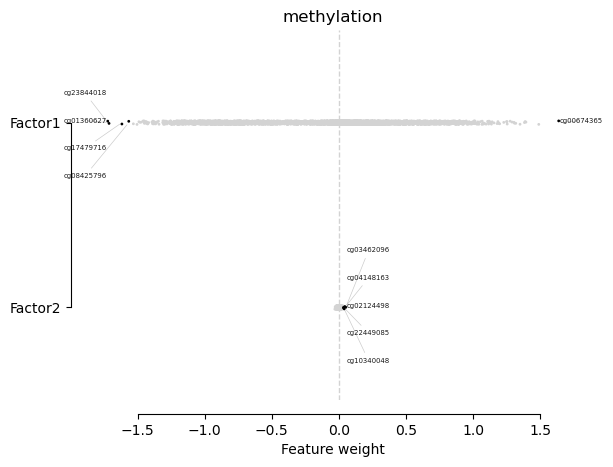

In [56]:
ax = mfx.plot_weights(
    model,
    views="methylation",
    factors=[0, 1],
    n_features=5,
)

#### Exercise

1. Check the factor loadings for Factor 1 and Factor 3 in the mutations modality. What do you expect regarding the IGHV and trisomy 12 variables?
2. The formula for the factorisation is $$y_{nd} = \sum_d w_{dk} z_{nk},$$ where $y_{nd}$ is the data value of observation $n$ and variable $d$, $w_{dk}$ is the factor loading of variable $d$ and factor $k$, and $z_{nk}$ is the factor score of sample $n$ and factor $k$. If a variable has a high positive value in a sample, and the corresponding factor score is also positive, what does this imply for the sign of the factor loading? Validate your assumption by looking at the factor scores of Factor 1, which separates samples by their IGHV status (remember how we encoded the IGHV mutation numerically).
3. We've seen that Factor 1 has high values for patients with IGHV mutation. Have a look at the factor loadings for the same factor in other modalities (like transcriptome or drug response) now. What does it mean for a variable to have a high positive or negative loading? Can you create hypotheses about potential drug targets or drug efficacy?

In [57]:
# Exercise 1
print(factor_loadings_mutations_df["Factor 1"].sort_values(ascending=False))
print(factor_loadings_mutations_df["Factor 3"].sort_values(ascending=False))

m_IGHV            1.717166
m_del13q14_any    0.000762
m_KLHL6           0.000574
m_ACTN2           0.000293
m_FOXC1           0.000198
                    ...   
m_MED12          -0.001012
m_ATM            -0.001183
m_del17p13       -0.001806
m_TP53           -0.038020
m_del11q22.3     -0.310160
Name: Factor 1, Length: 69, dtype: float64
m_trisomy12       0.886498
m_gain14q32       0.023301
m_EGR2            0.005314
m_IGHV            0.004952
m_CREBBP          0.002901
                    ...   
m_ATM            -0.001894
m_XPO1           -0.002401
m_TP53           -0.003336
m_del11q22.3     -0.043125
m_del13q14_any   -0.553264
Name: Factor 3, Length: 69, dtype: float64


In [58]:
# Exercise 2
# Patients with IGHV mutations (encoded as "1") have positive Factor 1 scores, so to get the "1" we also expect the weight to be positive.

In [59]:
# Exercise 3
# In general, when the product of factor score and loading is large, the corresponding feature in the sample should also be large.

Finally, let us try to link the individual factors to some known biological processes. This can be done using gene set enrichment analysis, a technique that takes as input a number of genes and searches a data base to identify biological processes (or anything else, depends on the data base) that involve roughly this set of genes. In our MOFA analysis, we can simply choose the genes that have an absolute value of the factor loadings above a certain threshold, because there are the genes that are important for the factor. We'll use the decoupler package for this purpose.

In [60]:
msigdb = dc.get_resource("MSigDB")
msigdb = msigdb[msigdb["collection"] == "reactome_pathways"]
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]

In [61]:
acts, norm_acts, pvals = dc.run_gsea(factor_loadings_mrna_df.T, msigdb, source="geneset", target="genesymbol", verbose=True)

Running gsea on mat with 15 samples and 5000 targets for 861 sources.


  0%|          | 0/15 [00:00<?, ?it/s]

In [62]:
acts.T

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10,Factor 11,Factor 12,Factor 13,Factor 14,Factor 15
source,,,,,,,,,,,,,,,
REACTOME_ABACAVIR_ADME,-0.652124,0.705497,-0.676263,0.434843,-0.614791,0.707001,-0.754616,-0.655610,-0.476167,0.410532,-0.377838,-0.799732,-0.676134,-0.637949,-0.792218
REACTOME_ABC_FAMILY_PROTEINS_MEDIATED_TRANSPORT,-0.515207,-0.274199,0.481334,0.650744,0.478377,0.637509,-0.326946,0.802923,-0.274077,0.492621,-0.414432,-0.438185,0.310595,-0.418932,-0.468619
REACTOME_ABC_TRANSPORTERS_IN_LIPID_HOMEOSTASIS,-0.740794,0.488895,0.577573,0.841186,0.694521,0.564301,-0.347217,-0.733451,0.364986,0.476931,-0.494564,-0.576277,0.582959,-0.467577,0.232317
REACTOME_ABC_TRANSPORTER_DISORDERS,-0.547195,-0.528685,-0.298197,-0.666039,0.634325,0.568904,-0.540903,0.714127,0.329931,0.446556,-0.333544,-0.494074,0.379174,-0.345966,0.292959
REACTOME_ABERRANT_REGULATION_OF_MITOTIC_G1_S_TRANSITION_IN_CANCER_DUE_TO_RB1_DEFECTS,-0.372060,-0.466770,0.777272,0.763136,-0.560270,-0.420506,0.484222,0.534467,0.389303,-0.538875,-0.258744,0.539932,-0.280524,0.565457,0.330658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
REACTOME_VITAMIN_B5_PANTOTHENATE_METABOLISM,0.626232,0.884171,-0.470415,0.729688,-0.618485,-0.834774,-0.438316,0.904036,0.899115,-0.350402,0.300979,-0.777240,-0.628829,0.458492,0.364629
REACTOME_VOLTAGE_GATED_POTASSIUM_CHANNELS,-0.337291,0.316398,0.499669,0.518225,-0.325856,-0.560590,0.616173,-0.493315,0.358432,-0.354022,-0.421706,-0.501528,-0.541742,-0.512093,0.688145
REACTOME_WNT_LIGAND_BIOGENESIS_AND_TRAFFICKING,-0.559269,-0.430778,-0.533621,0.609397,-0.245364,-0.475536,0.354687,-0.521613,0.454310,-0.399671,-0.520100,-0.574721,0.503704,0.428404,-0.307830


#### Exercise
1. How can this table be interpreted? 
2. Sort the rows according to the values of individual factors. Is there a factor for which the top gene sets share a common theme?
3. Try doing the same analysis with a different gene set collection.

In [63]:
# Exercise 1
# The individual values give an idea of how strongly a factor (using its loadings) is associated with a gene set / pathway / ...

In [64]:
acts.T["Factor 1"].sort_values(ascending=False)

source
REACTOME_GRB2_SOS_PROVIDES_LINKAGE_TO_MAPK_SIGNALING_FOR_INTEGRINS                    0.920818
REACTOME_P130CAS_LINKAGE_TO_MAPK_SIGNALING_FOR_INTEGRINS                              0.920818
REACTOME_INTEGRIN_SIGNALING                                                           0.915625
REACTOME_RUNX1_AND_FOXP3_CONTROL_THE_DEVELOPMENT_OF_REGULATORY_T_LYMPHOCYTES_TREGS    0.904117
REACTOME_NR1H2_NR1H3_REGULATE_GENE_EXPRESSION_LINKED_TO_LIPOGENESIS                   0.899026
                                                                                        ...   
REACTOME_ROLE_OF_PHOSPHOLIPIDS_IN_PHAGOCYTOSIS                                       -0.863039
REACTOME_SYNTHESIS_OF_PA                                                             -0.865048
REACTOME_ACETYLCHOLINE_REGULATES_INSULIN_SECRETION                                   -0.896537
REACTOME_MAP2K_AND_MAPK_ACTIVATION                                                   -0.902788
REACTOME_FORMYL_PEPTIDE_RECEPTORS_BIND_FORM

With this, you gained quite some insight in training and analysing a MOFA model. The official part of the project is now over, hopefully you enjoyed it and learned something useful for your own research! But feel free to try out more things - there's a lot to explore and you could also look at other public multi-omics data sets and maybe find something interesting?

#### Additional Exercises (if you have time and according to your interests)
1. Browse the [MOFA website](https://biofam.github.io/MOFA2/index.html)
2. Try to train a MOFA model on the same data in R
3. What is MEFISTO about? If you're interested, read [the paper](https://www.nature.com/articles/s41592-021-01343-9) or look into one of the [tutorials](https://biofam.github.io/MOFA2/MEFISTO.html).
4. Find another public Multi-Omics dataset and apply MOFA (look for example [here](https://github.com/PMBio/mudatasets/tree/main/mudatasets/datasets))
5. If you want to deep dive in developing your own factor models, have a look at the probabilistic programming language [Pyro](https://pyro.ai/). You can find a very basic factor model to build on, implemented in Pyro, [here](https://github.com/florinwalter/pyro_models/blob/main/src/models/factor_analysis.py).